## <center>Goal: Scrape data table from a wikipedia, clean data, and plot cylindrical LIB cell energies</center>
#### <center>Thank you to Codecademy, PY4E, and Sateesh110 on GitHub for the bs4 and html codes they have published</center>

The response status code from the URL request is 200


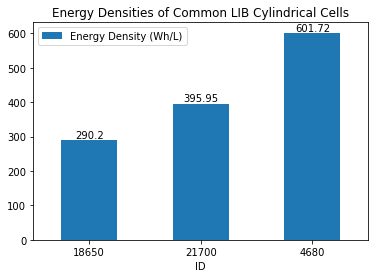

In [1]:
# Import Modules

import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt

# Assign our desired URL to scrape
url = "https://en.wikipedia.org/wiki/List_of_battery_sizes"

# Get HTML response and check availabilty
response = requests.get(url)
print("The response status code from the URL request is", response.status_code)

# Parse data from HTML into bs4 object
# Create pd df and choose correct table index using browser "Inspect"/manually identifying
soup = BeautifulSoup(response.text, 'html.parser') # I love that pandas can only read the soup after it is prettified
df = pd.read_html(soup.prettify())[-4]             # Could I somewhow split using a keyword to make it more automated?                

# Rename columns and drop unwanted
column_labels = ["ID", "Alt ID", "Capacity (mAh/cell)", "Diameter (mm)", "Length (mm)", "Desc."]
df.columns = column_labels
columns_to_drop = ['Alt ID', 'Desc.']
df.drop(columns_to_drop,inplace = True, axis=1)

# Strip unwanted characters and take low-end of capacity values
df['Capacity (mAh/cell)'] = df['Capacity (mAh/cell)'].str.replace('–', ' ')
df['Capacity (mAh/cell)'] = df['Capacity (mAh/cell)'].str.split(' ').str[0]
df['ID'] = df['ID'].str.split(' ').str[0]

# Calculate and create 'Volume' Column 
volume = []
for index, row in df.iterrows():
    volume.append((np.pi * (row['Diameter (mm)'] /2)**2) * row['Length (mm)'])
df['Volume'] = volume

# Make all values floats (thank you @anki_91 StackOverflow)
df = df.replace(',','', regex=True)
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')

# Convert mm^3 to L, Convert mAh to Wh and add column
df['Volume'] = df['Volume'] / 1e6    
LIB_Voltage = 3.2 # Average voltage of LIB cell
watt_hours = []

for index, row in df.iterrows():
    watt_hours.append((row['Capacity (mAh/cell)']) / 1000 * LIB_Voltage)
    
df['Energy Output (Wh)'] = watt_hours
df.rename(columns = {'Volume':'Volume (L)'}, inplace = True)

# Calculate Volumetric Energy Density and add column
df['Energy Density (Wh/L)'] = df['Energy Output (Wh)'] / df['Volume (L)']

# Round to two decimal places
df = df.applymap(lambda x: round(x, 2))

# Plot common LIB cell energies
rows_to_plot = [18650, 21700, 4680]
df = df.loc[df['ID'].isin(rows_to_plot)]
chart = df.plot.bar(x = 'ID', y = 'Energy Density (Wh/L)', rot = 0, title = 'Energy Densities of Common LIB Cylindrical Cells')
for container in chart.containers:
    chart.bar_label(container)
